In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
test = pd.read_csv('../raw_data/test.csv')
data = pd.read_csv('../raw_data/train.csv')

In [3]:
data.Cabin.isnull().sum() / data.shape[0] # 0.7710437710437711
data = data.drop(columns='Cabin')

In [35]:
from missingpy import MissForest
mf_imputer = MissForest()

/home/maciek/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2

In [36]:
missing_features = ['Age', 'Embarked']
missing_imputer = MissForest()

In [18]:
import re

titles = [y[1] for y in [re.search('([A-Za-z]+\.)', x) for x in data.Name]]
titles = [x[:-1] for x in titles]

common = ['Mr', 'Miss', 'Mrs', 'Mlle', 'Ms', 'Mme']

titles = [0 if x in common else 1 for x in titles ]

data['Titles'] = titles

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
class TitleTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        titles = [y[1] for y in [re.search('([A-Za-z]+\.)', x) for x in X]]
        titles = [x[:-1] for x in titles]
        common = ['Mr', 'Miss', 'Mrs', 'Mlle', 'Ms', 'Mme']
        X = [0 if x in common else 1 for x in titles ]
        return pd.DataFrame(X)

In [21]:
from sklearn.pipeline import Pipeline

In [63]:
from sklearn.compose import ColumnTransformer
trans = ColumnTransformer([('title_transformer', TitleTransformer(), 'Name')], remainder='drop')

In [64]:
trans

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('title_transformer', TitleTransformer(),
                                 'Name')],
                  verbose=False)

In [65]:
trans.fit(data)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('title_transformer', TitleTransformer(),
                                 'Name')],
                  verbose=False)

In [67]:
trans.transform(data)

(891, 1)

In [44]:
titles_pipe = Pipeline(steps=[('Name',
                               TitleTransformer())])
transformed_df = titles_pipe.fit(data)

In [45]:
titles_pipe.transform(data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,0


In [5]:
pd.value_counts(titles)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
dtype: int64

In [8]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(data[['Sex', 'Pclass', 'Titles']])
encoded = pd.DataFrame(data=ohe.transform(data[['Sex', 'Pclass', 'Titles']]),
                       columns=ohe.get_feature_names(['Sex', 'Pclass', 'Titles']))

In [15]:
data.join(encoded).drop(columns=['PassengerId', 'Name', 'Sex', 'Parch','Titles'])

,Survived,Pclass,Age,SibSp,Ticket,Fare,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Titles_common,Titles_special
0,0,3,22.0,1,A/5 21171,7.2500,S,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1,1,38.0,1,PC 17599,71.2833,C,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,3,26.0,0,STON/O2. 3101282,7.9250,S,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1,1,35.0,1,113803,53.1000,S,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,3,35.0,0,373450,8.0500,S,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,211536,13.0000,S,0.0,1.0,0.0,1.0,0.0,0.0,1.0
887,1,1,19.0,0,112053,30.0000,S,1.0,0.0,1.0,0.0,0.0,1.0,0.0
888,0,3,NaN,1,W./C. 6607,23.4500,S,1.0,0.0,0.0,0.0,1.0,1.0,0.0
889,1,1,26.0,0,111369,30.0000,C,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [11]:
numeric_features = ["Fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["Embarked", "Sex", "Pclass"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [12]:
preprocessor.fit_transform(data)

ValueError: Input contains NaN

In [31]:
mf_imputer.fit(data)

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [30]:
age_imputed = mf_imputer.fit_transform(data.Age)

ValueError: Expected 2D array, got 1D array instead:
array=[22.   38.   26.   35.   35.     nan 54.    2.   27.   14.    4.   58.
 20.   39.   14.   55.    2.     nan 31.     nan 35.   34.   15.   28.
  8.   38.     nan 19.     nan   nan 40.     nan   nan 66.   28.   42.
   nan 21.   18.   14.   40.   27.     nan  3.   19.     nan   nan   nan
   nan 18.    7.   21.   49.   29.   65.     nan 21.   28.5   5.   11.
 22.   38.   45.    4.     nan   nan 29.   19.   17.   26.   32.   16.
 21.   26.   32.   25.     nan   nan  0.83 30.   22.   29.     nan 28.
 17.   33.   16.     nan 23.   24.   29.   20.   46.   26.   59.     nan
 71.   23.   34.   34.   28.     nan 21.   33.   37.   28.   21.     nan
 38.     nan 47.   14.5  22.   20.   17.   21.   70.5  29.   24.    2.
 21.     nan 32.5  32.5  54.   12.     nan 24.     nan 45.   33.   20.
 47.   29.   25.   23.   19.   37.   16.   24.     nan 22.   24.   19.
 18.   19.   27.    9.   36.5  42.   51.   22.   55.5  40.5    nan 51.
 16.   30.     nan   nan 44.   40.   26.   17.    1.    9.     nan 45.
   nan 28.   61.    4.    1.   21.   56.   18.     nan 50.   30.   36.
   nan   nan  9.    1.    4.     nan   nan 45.   40.   36.   32.   19.
 19.    3.   44.   58.     nan 42.     nan 24.   28.     nan 34.   45.5
 18.    2.   32.   26.   16.   40.   24.   35.   22.   30.     nan 31.
 27.   42.   32.   30.   16.   27.   51.     nan 38.   22.   19.   20.5
 18.     nan 35.   29.   59.    5.   24.     nan 44.    8.   19.   33.
   nan   nan 29.   22.   30.   44.   25.   24.   37.   54.     nan 29.
 62.   30.   41.   29.     nan 30.   35.   50.     nan  3.   52.   40.
   nan 36.   16.   25.   58.   35.     nan 25.   41.   37.     nan 63.
 45.     nan  7.   35.   65.   28.   16.   19.     nan 33.   30.   22.
 42.   22.   26.   19.   36.   24.   24.     nan 23.5   2.     nan 50.
   nan   nan 19.     nan   nan  0.92   nan 17.   30.   30.   24.   18.
 26.   28.   43.   26.   24.   54.   31.   40.   22.   27.   30.   22.
   nan 36.   61.   36.   31.   16.     nan 45.5  38.   16.     nan   nan
 29.   41.   45.   45.    2.   24.   28.   25.   36.   24.   40.     nan
  3.   42.   23.     nan 15.   25.     nan 28.   22.   38.     nan   nan
 40.   29.   45.   35.     nan 30.   60.     nan   nan 24.   25.   18.
 19.   22.    3.     nan 22.   27.   20.   19.   42.    1.   32.   35.
   nan 18.    1.   36.     nan 17.   36.   21.   28.   23.   24.   22.
 31.   46.   23.   28.   39.   26.   21.   28.   20.   34.   51.    3.
 21.     nan   nan   nan 33.     nan 44.     nan 34.   18.   30.   10.
   nan 21.   29.   28.   18.     nan 28.   19.     nan 32.   28.     nan
 42.   17.   50.   14.   21.   24.   64.   31.   45.   20.   25.   28.
   nan  4.   13.   34.    5.   52.   36.     nan 30.   49.     nan 29.
 65.     nan 50.     nan 48.   34.   47.   48.     nan 38.     nan 56.
   nan  0.75   nan 38.   33.   23.   22.     nan 34.   29.   22.    2.
  9.     nan 50.   63.   25.     nan 35.   58.   30.    9.     nan 21.
 55.   71.   21.     nan 54.     nan 25.   24.   17.   21.     nan 37.
 16.   18.   33.     nan 28.   26.   29.     nan 36.   54.   24.   47.
 34.     nan 36.   32.   30.   22.     nan 44.     nan 40.5  50.     nan
 39.   23.    2.     nan 17.     nan 30.    7.   45.   30.     nan 22.
 36.    9.   11.   32.   50.   64.   19.     nan 33.    8.   17.   27.
   nan 22.   22.   62.   48.     nan 39.   36.     nan 40.   28.     nan
   nan 24.   19.   29.     nan 32.   62.   53.   36.     nan 16.   19.
 34.   39.     nan 32.   25.   39.   54.   36.     nan 18.   47.   60.
 22.     nan 35.   52.   47.     nan 37.   36.     nan 49.     nan 49.
 24.     nan   nan 44.   35.   36.   30.   27.   22.   40.   39.     nan
   nan   nan 35.   24.   34.   26.    4.   26.   27.   42.   20.   21.
 21.   61.   57.   21.   26.     nan 80.   51.   32.     nan  9.   28.
 32.   31.   41.     nan 20.   24.    2.     nan  0.75 48.   19.   56.
   nan 23.     nan 18.   21.     nan 18.   24.     nan 32.   23.   58.
 50.   40.   47.   36.   20.   32.   25.     nan 43.     nan 40.   31.
 70.   31.     nan 18.   24.5  18.   43.   36.     nan 27.   20.   14.
 60.   25.   14.   19.   18.   15.   31.    4.     nan 25.   60.   52.
 44.     nan 49.   42.   18.   35.   18.   25.   26.   39.   45.   42.
 22.     nan 24.     nan 48.   29.   52.   19.   38.   27.     nan 33.
  6.   17.   34.   50.   27.   20.   30.     nan 25.   25.   29.   11.
   nan 23.   23.   28.5  48.   35.     nan   nan   nan 36.   21.   24.
 31.   70.   16.   30.   19.   31.    4.    6.   33.   23.   48.    0.67
 28.   18.   34.   33.     nan 41.   20.   36.   16.   51.     nan 30.5
   nan 32.   24.   48.   57.     nan 54.   18.     nan  5.     nan 43.
 13.   17.   29.     nan 25.   25.   18.    8.    1.   46.     nan 16.
   nan   nan 25.   39.   49.   31.   30.   30.   34.   31.   11.    0.42
 27.   31.   39.   18.   39.   33.   26.   39.   35.    6.   30.5    nan
 23.   31.   43.   10.   52.   27.   38.   27.    2.     nan   nan  1.
   nan 62.   15.    0.83   nan 23.   18.   39.   21.     nan 32.     nan
 20.   16.   30.   34.5  17.   42.     nan 35.   28.     nan  4.   74.
  9.   16.   44.   18.   45.   51.   24.     nan 41.   21.   48.     nan
 24.   42.   27.   31.     nan  4.   26.   47.   33.   47.   28.   15.
 20.   19.     nan 56.   25.   33.   22.   28.   25.   39.   27.   19.
   nan 26.   32.  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [6]:
data.shape

(891, 11)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [18]:
data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S
524,525,0,3,"Kassem, Mr. Fared",male,NaN,0,0,2700,7.2292,NaN,C
315,316,1,3,"Nilsson, Miss. Helmina Josefina",female,26.0,0,0,347470,7.8542,NaN,S


In [19]:
data['Pclass'].

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: int64

In [13]:
data.corr().sort_values('Survived')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307


In [55]:
for x in data.columns:
    print(f'{data[x].value_counts()}\n\n-------------\n')

1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: PassengerId, Length: 891, dtype: int64

-------------

0    549
1    342
Name: Survived, dtype: int64

-------------

3    491
1    216
2    184
Name: Pclass, dtype: int64

-------------

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

-------------

male      577
female    314
Name: Sex, dtype: int64

-------------

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50  

<AxesSubplot:>

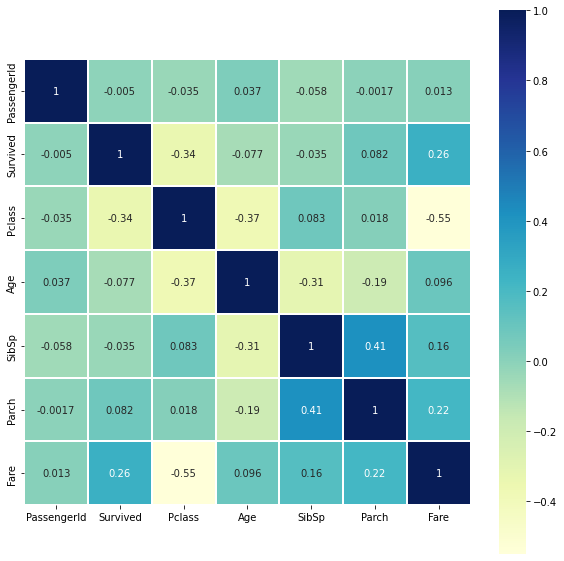

In [11]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), linewidths=0.01, vmax= 1, square=True,annot=True,cmap='YlGnBu',linecolor="white")

<AxesSubplot:ylabel='Frequency'>

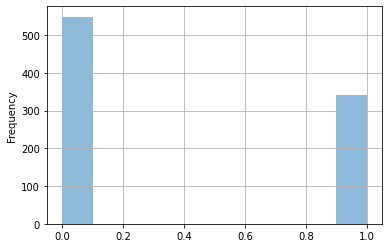

In [5]:
data.Survived.plot(kind='hist', alpha = 0.5, grid=True)

<AxesSubplot:>

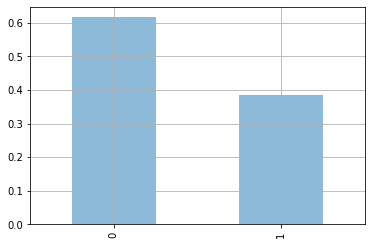

In [6]:
data.Survived.value_counts(normalize=True).plot(kind='bar', alpha = 0.5, grid=True)

In [7]:
[int(x/data.shape[0] * 100) for x in data.Survived.value_counts()]

[61, 38]

In [28]:
((data[data['Sex'] == 'male'][data['Pclass'] == 1]['Survived'].sum() /
 data[data['Sex'] == 'male'][data['Pclass'] == 1].shape[0] * 100) + (
     data[data['Sex'] == 'male'][data['Pclass'] == 2]['Survived'].sum() /
     data[data['Sex'] == 'male'][data['Pclass'] == 2].shape[0] * 100) + (
         data[data['Sex'] == 'male'][data['Pclass'] == 3]['Survived'].sum() /
         data[data['Sex'] == 'male'][data['Pclass'] == 3].shape[0] * 100)) / 3

/tmp/ipykernel_697/697995920.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((data[data['Sex'] == 'male'][data['Pclass'] == 1]['Survived'].sum() /
/tmp/ipykernel_697/697995920.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'male'][data['Pclass'] == 1].shape[0] * 100) + (
/tmp/ipykernel_697/697995920.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'male'][data['Pclass'] == 2]['Survived'].sum() /
/tmp/ipykernel_697/697995920.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'male'][data['Pclass'] == 2].shape[0] * 100) + (
/tmp/ipykernel_697/697995920.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['Sex'] == 'male'][data['Pclass'] == 3]['Survived'].sum() /
/tmp/ipykernel_697/697995920.py:6: UserWarning: Boolean Series key will be reindexed to 

22.05688507675878

In [33]:
data[data['Sex'] == 'male'].Survived.sum() / 577

0.18890814558058924

In [6]:
survival_rate = data.groupby(['Sex']).mean()[['Survived']]
male_rate = survival_rate.loc['male']
female_rate = survival_rate.loc['female']
display(survival_rate)

,Survived
Sex,
female,0.742038
male,0.188908


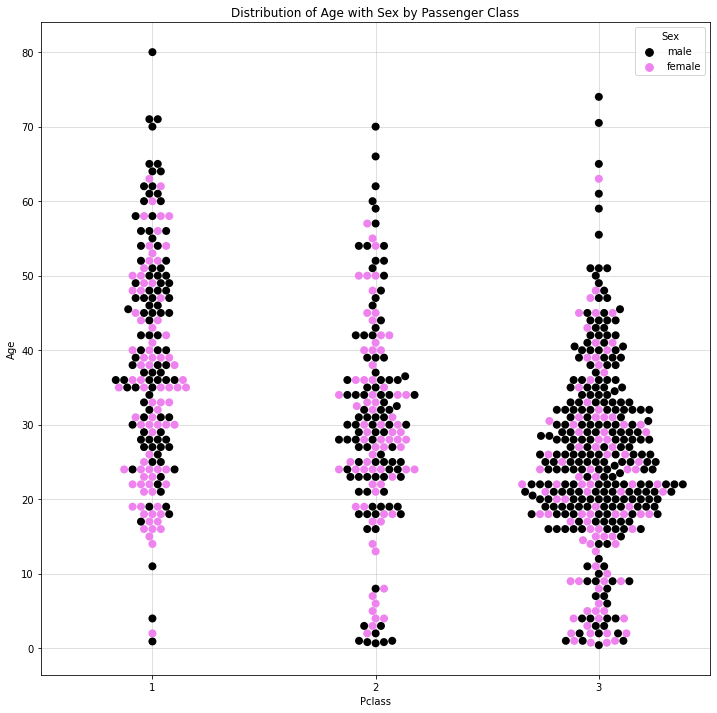

In [4]:
plt.figure(figsize=(12, 12))
sns.swarmplot(data=data,
              x='Pclass',
              y='Age',
              hue='Sex',
              size=8,
              palette=[
                  'black', 'violet'
              ]).set(title='Distribution of Age with Sex by Passenger Class')
plt.grid(alpha=.5)

In [80]:
np.mean(data.Survived)

0.3838383838383838

In [106]:
s = pd.DataFrame()

In [116]:
round(np.mean(data[(data.Pclass == 1) & (data.Sex =='female')].Survived), 2)

0.97

In [5]:
def get_survival_rate_per_sex_and_class():
    li = []
    for x in [1, 2, 3]:
        #temp = []
        li.append(
            round(
                np.mean(data[(data.Pclass == x)
                             & (data.Sex == 'female')].Survived), 2))
        li.append(
            round(
                np.mean(data[(data.Pclass == x)
                             & (data.Sex == 'male')].Survived), 2))
        #li.append(temp)
    return pd.DataFrame({
        'Class' : [1,1,2,2,3,3],
        'Survived': li,
        'Sex': ['female', 'male', 'female', 'male', 'female', 'male']
    })

sex_class_survival = get_survival_rate_per_sex_and_class()

In [6]:
sex_class_survival

,Class,Survived,Sex
0,1,0.97,female
1,1,0.37,male
2,2,0.92,female
3,2,0.16,male
4,3,0.50,female
5,3,0.14,male


([<matplotlib.axis.XTick at 0x7f4d7b5fafa0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

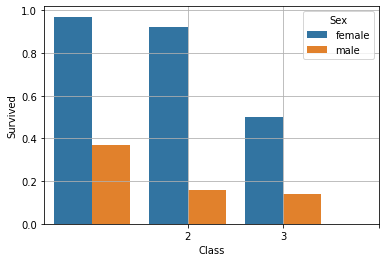

In [52]:
sns.barplot(data = sex_class_survival, x = 'Class', y = 'Survived', hue = 'Sex')
plt.grid()
plt.xticks(np.arange(1,4, 1))

In [94]:
np.mean(data[(data.Pclass == 3) & (data.Sex =='female')].Survived)

0.5

In [85]:
np.mean(data[(data.Parch > 0) & (data.SibSp > 0)].Survived)

0.43661971830985913

In [74]:
data[data.Ticket.duplicated(keep=False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
...,...,...,...,...,...,...,...,...,...,...,...,...
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


In [51]:
for x in data.select_dtypes(int).columns:
    print(x)

PassengerId
Survived
Pclass
SibSp
Parch


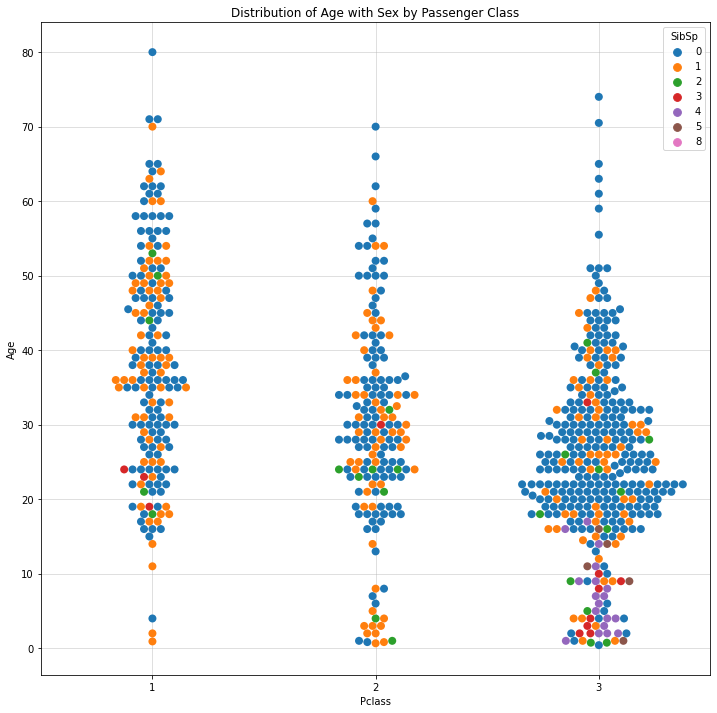

In [59]:
plt.figure(figsize=(12, 12))
sns.swarmplot(data=data,
              x='Pclass',
              y='Age',
              hue='SibSp',
              size=8).set(title='Distribution of Age with Sex by Passenger Class')
plt.grid(alpha=.5)

In [8]:
class_survival_rate = data.groupby(['Pclass']).mean()[['Survived']]

In [55]:
class_survival_rate

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [6]:
survival_rate

,Survived
Sex,
female,0.742038
male,0.188908


In [5]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [53]:
data.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

<AxesSubplot:xlabel='Sex', ylabel='Count'>

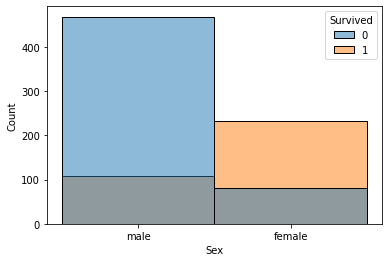

In [78]:
sns.histplot(data = data, x = 'Sex', hue = 'Survived')

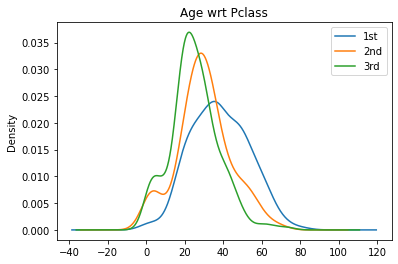

In [41]:
for x in [1,2,3]:
    data.Age[data.Pclass == x].plot(kind="kde")
    
plt.title("Age wrt Pclass")
plt.legend(("1st","2nd","3rd"))

<AxesSubplot:xlabel='Age', ylabel='Pclass'>

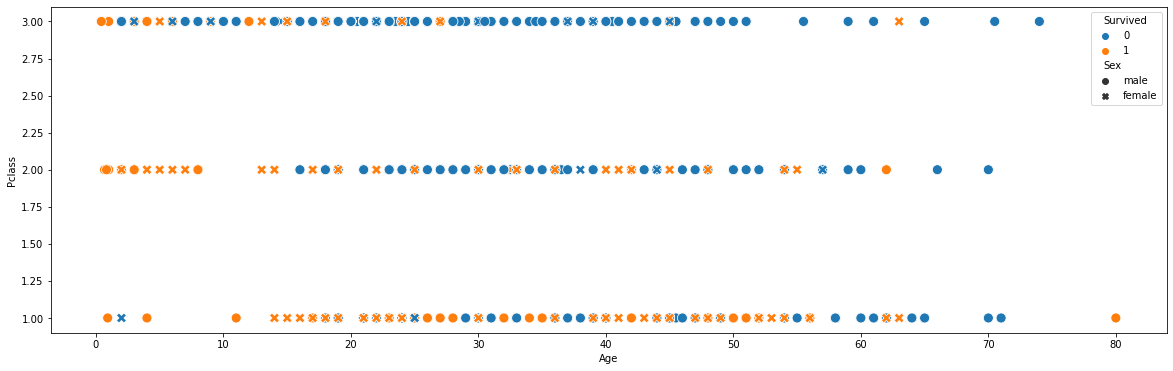

In [19]:
plt.figure(figsize=(20,6))
sns.scatterplot(data = data, y = 'Pclass', x = 'Age', hue='Survived', style='Sex', s = 100)

In [11]:
data.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<Figure size 864x576 with 0 Axes>

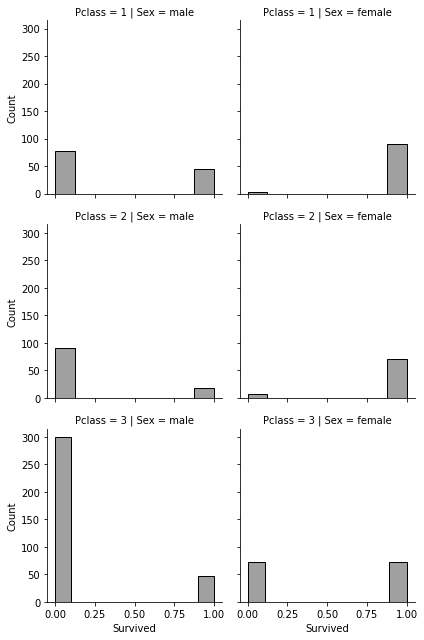

In [59]:
plt.figure(figsize=(12,8))
g = sns.FacetGrid(data = data, row = 'Pclass', col = 'Sex')
g.map(sns.histplot, 'Survived', color = 'gray')

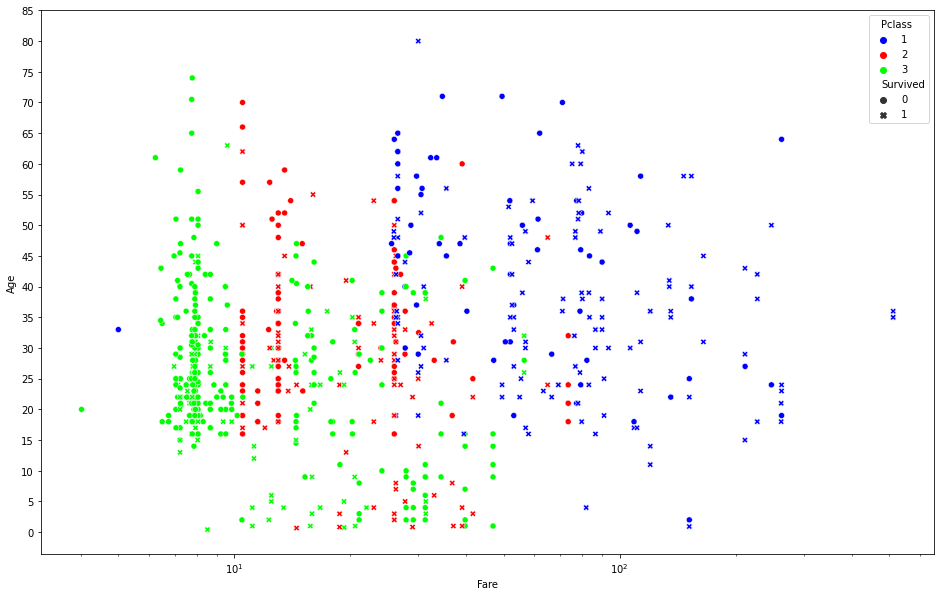

In [50]:
plt.figure(figsize = (16,10))
ax = sns.scatterplot(data = data, y = 'Age', x = 'Fare', hue='Pclass', style='Survived', palette = 'brg')
ax.set_yticks(range(0,90, 5))
ax.set_xscale('log')

# Feature Engineering

In [20]:
data.Name.head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

# Null hypothesis

In [215]:
sample = data.sample(n=150, random_state=100)

<AxesSubplot:ylabel='Frequency'>

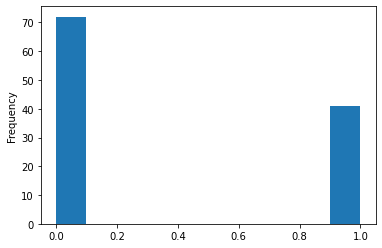

In [222]:
sample[sample.Parch == 0].Survived.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

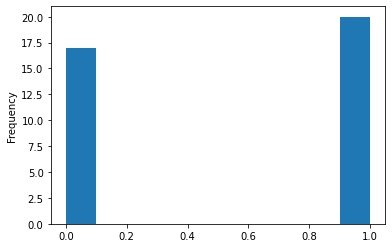

In [221]:
sample[sample.Parch > 0].Survived.plot(kind='hist')

In [223]:
from scipy.stats import t
rv = t(df=100-2)